# Predicting MRI from simultaneous EEG recordings



*EEG (avg or FCz referenced) to MRI BOLD translation (MRI with Harvard-Oxford Parcellated based on MNI152 space)*


This notebook details filtering, feature extraction and basic model training for a simple feedforward ANN for predicting MRI BOLD signal from simultaneous EEG recordings. The program uses simple festures such as energy in the delta through to gamma bands as predictors (delta band power has shown to be correlated with cortical BOLD in resting wakefulness). Other possible features include low average frequency IMFs from EMD-based analysis and information 

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from dipy.sims.voxel import (multi_tensor_dki, single_tensor)
from dipy.data import get_fnames
from dipy.io.gradients import read_bvals_bvecs
from dipy.core.gradients import gradient_table
from dipy.reconst.dti import (decompose_tensor, from_lower_triangular)

In [67]:
import tensorflow as tf
import mne#a package for analysing EEG data
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.signal import butter,lfilter
from lspopt.lsp import spectrogram_lspopt
import random
import sklearn
import glob
fs=250

#Butterworth bandpass filter
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut=0.1, highcut=100, fs=fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

# Simulated EEG data

In [68]:
import colorednoise as cn
sim_time = 600 #600 seconds of simulated data
beta = 1 # the exponent
eeg_samples = fs*sim_time # number of samples to generate
channels = 10
eeg_data = np.zeros((eeg_samples,channels))
for i in range(channels):
    eeg_data[:,i] = cn.powerlaw_psd_gaussian(beta, eeg_samples)

In [69]:
import os.path as op

import numpy as np

import mne
from mne.datasets import sample

def generate_mne_data():
    # For this example, we will be using the information of the sample subject.
    # This will download the data if it not already on your machine. We also set
    # the subjects directory so we don't need to give it to functions.
    data_path = sample.data_path()
    subjects_dir = op.join(data_path, 'subjects')
    subject = 'sample'

    # First, we get an info structure from the test subject.
    evoked_fname = op.join(data_path, 'MEG', subject, 'sample_audvis-ave.fif')
    info = mne.io.read_info(evoked_fname)
    tstep = 1. / info['sfreq']

    # To simulate sources, we also need a source space. It can be obtained from the
    # forward solution of the sample subject.
    fwd_fname = op.join(data_path, 'MEG', subject,
                        'sample_audvis-meg-eeg-oct-6-fwd.fif')
    fwd = mne.read_forward_solution(fwd_fname)
    src = fwd['src']

    # To select a region to activate, we use the caudal middle frontal to grow
    # a region of interest.
    selected_label = mne.read_labels_from_annot(
        subject, regexp='caudalmiddlefrontal-lh', subjects_dir=subjects_dir)[0]
    location = 'center'  # Use the center of the region as a seed.
    extent = 10.  # Extent in mm of the region.
    label = mne.label.select_sources(
        subject, selected_label, location=location, extent=extent,
        subjects_dir=subjects_dir)

    # Define the time course of the activity for each source of the region to
    # activate. Here we use a sine wave at 18 Hz with a peak amplitude
    # of 10 nAm.
    source_time_series = np.sin(2. * np.pi * 18. * np.arange(100) * tstep) * 10e-9

    # Define when the activity occurs using events. The first column is the sample
    # of the event, the second is not used, and the third is the event id. Here the
    # events occur every 200 samples.
    n_events = 50
    events = np.zeros((n_events, 3), int)
    events[:, 0] = 100 + 200 * np.arange(n_events)  # Events sample.
    events[:, 2] = 1  # All events have the sample id.

    # Create simulated source activity. Here we use a SourceSimulator whose
    # add_data method is key. It specified where (label), what
    # (source_time_series), and when (events) an event type will occur.
    source_simulator = mne.simulation.SourceSimulator(src, tstep=tstep,duration=300)
    source_simulator.add_data(label, source_time_series, events)

    # Project the source time series to sensor space and add some noise. The source
    # simulator can be given directly to the simulate_raw function.
    raw = mne.simulation.simulate_raw(info, source_simulator, forward=fwd)
    cov = mne.make_ad_hoc_cov(raw.info)
    mne.simulation.add_noise(raw, cov, iir_filter=[0.2, -0.2, 0.04])


    # Plot evoked data to get another view of the simulated raw data.
    events = mne.find_events(raw)
    epochs = mne.Epochs(raw, events, 1, tmin=-0.05, tmax=0.2)
    evoked = epochs.average()
    EEG_channels= ['EEG 001',
     'EEG 002',
     'EEG 003',
     'EEG 004',
     'EEG 005',
     'EEG 006',
     'EEG 007',
     'EEG 008',
     'EEG 009',
     'EEG 010']
    raw_temp=raw.copy()
    raw_temp.pick_channels(EEG_channels)
    t = mne.simulation.add_noise(raw_temp, cov, iir_filter=[0.2, -0.2, 0.04])
    eeg_data= t.get_data()
    eeg_data= eeg_data.reshape(180184,10)
    eeg_data=eeg_data[:150000]
    return eeg_data

In [70]:
eeg_data =generate_mne_data()

    Read a total of 4 projection items:
        PCA-v1 (1 x 102) active
        PCA-v2 (1 x 102) active
        PCA-v3 (1 x 102) active
        Average EEG reference (1 x 60) active
Reading forward solution from /Users/ssackstein/mne_data/MNE-sample-data/MEG/sample/sample_audvis-meg-eeg-oct-6-fwd.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523) not available
    Read MEG forward solution (7498 sources, 306 channels, free orientations)
    Desired named matrix (kind = 3523) not available
    Read EEG forward solution (7498 sources, 60 channels, free orientations)
    MEG and EEG forward solutions combined
    Source spaces transformed to the forward solution coordinate frame
Reading labels 

In [71]:
eeg_data.shape

(150000, 10)

In [72]:
eeg_data[1,:]

array([ 1.86731915e-06,  2.45119794e-06, -1.72114865e-07, -1.11623006e-06,
       -1.92991288e-06,  3.36709268e-07,  1.55441976e-06,  2.30839167e-06,
        2.00779940e-06, -4.26471722e-07])

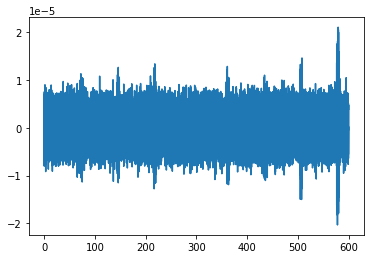

In [73]:
plt.plot(np.arange(0,sim_time,1/fs),eeg_data[:,i])

# Simple feature extraction for EEG data

In [74]:
def get_f_bands(f):
    f_sw = [k for k in range(len(f)) if f[k]<=1.5 and f[k]>0.1]
    #literature suggests a robust correlation between EEG <1.5Hz and cortical MRI
    f_delta = [k for k in range(len(f)) if f[k]>1.5 and f[k]<=4]
    f_theta = [k for k in range(len(f)) if f[k]>4 and f[k]<=8]
    f_alpha = [k for k in range(len(f)) if f[k]>8 and f[k]<=12]
    f_beta = [k for k in range(len(f)) if f[k]>12 and f[k]<=24]
    f_gamma = [k for k in range(len(f)) if f[k]>24]
    f_bands = [f_sw,f_delta,f_theta,f_alpha,f_beta,f_gamma]
    return f_bands

def get_power_data(data,window=2,use_mne=0,r=fs):
    #data - mne readable file (if use_mne) or numpy array (ch_data,ch)
    #window = size of sample window
    #r - moving avg sliding window, default to 1 second
    if use_mne: 
        raw=mne.io.read_raw_brainvision(file,preload=True).resample(fs, npad='auto')
        eeg = raw.copy().pick_types(meg=False, eeg=True, eog=False)
        eeg_data = eeg[:][0]
    else:
        eeg_data = data
    f, t, Sxx = spectrogram_lspopt(eeg_data[:,0], fs=fs,nperseg=window*fs,noverlap=window*fs-1,c_parameter=20)
    f_bands = get_f_bands(f)
    p_len = len(pd.Series(np.sum(Sxx[f_bands[0],:],axis=0)).rolling(r).median()[r-1:])
    power_data = np.zeros((p_len,eeg_data.shape[1]*len(f_bands)))   
    for i in range(eeg_data.shape[1]):
        eeg_data[:,i] = butter_bandpass_filter(eeg_data[:,i])#optional butter bandpass
        f, t, Sxx = spectrogram_lspopt(eeg_data[:,i], fs=fs,nperseg=window*fs,noverlap=window*fs-1,c_parameter=20)
        for b in range(len(f_bands)):
            power_data[:,i*len(f_bands)+b] = pd.Series(np.sum(Sxx[f_bands[b],:],axis=0)).rolling(r).median()[r-1:]
        print('Channel ' + str(i+1)+' done')
    power_data = np.log(power_data)
    return power_data,t[r-1:]

In [75]:
data_list = [eeg_data]#eeg_data or list of files
power_data = []
t_data = []
for data in data_list:
    p,t=get_power_data(data)
    t_data.append(t)
    power_data.append(p)

Channel 1 done
Channel 2 done
Channel 3 done
Channel 4 done
Channel 5 done
Channel 6 done
Channel 7 done
Channel 8 done
Channel 9 done
Channel 10 done


In [84]:
power_data[0].shape

(149252, 60)

# Marker extraction code (if they exists)

In [78]:
#raw=mne.io.read_raw_brainvision(EEG_files[0],preload=True)
#annot = mne.read_annotations('mark_test.vmrk')
#raw.set_annotations(annot)

annot = mne.read_annotations(EEG_mark[1],1000)
annot

# Simulation code

In [221]:
def get_MRI_baseline():
    fimg, fbvals, fbvecs = get_fnames('small_64D')
    bvals, bvecs = read_bvals_bvecs(fbvals, fbvecs)
    bvals = np.concatenate((bvals, bvals * 2), axis=0)
    bvecs = np.concatenate((bvecs, bvecs), axis=0)
    gtab = gradient_table(bvals, bvecs)
    eeg= np.array([1.45704796e-06, 1.75558268e-06, 1.55654514e-06, 1.44484317e-06,
       2.11409969e-06, 4.20040075e-06, 3.64490848e-06, 3.12608849e-06,
       1.26340068e-06, 6.83264224e-07])
    n = np.array([np.mean(eeg),np.std(eeg)])
    mevals =np.concatenate((eeg, n), axis=None).reshape(4,3)
    angles = [(90, 0), (90, 0), (20, 0), (20, 0)]
    fie = 0.49  # intra-axonal water fraction
    fractions = [fie*50, (1 - fie)*50, fie*50, (1 - fie)*50]
    signal_dki, dt, kt = multi_tensor_dki(gtab, mevals, S0=200, angles=angles,
                                          fractions=fractions, snr=None)
    signal_noisy, dt, kt = multi_tensor_dki(gtab, mevals, S0=200,
                                            angles=angles, fractions=fractions,
                                            snr=10)
    dt_evals, dt_evecs = decompose_tensor(from_lower_triangular(dt))
    signal_dti = single_tensor(gtab, S0=200, evals=dt_evals, evecs=dt_evecs,
                               snr=None)
    
    signal =np.array([])
    for i in range(3):
        eeg= eeg_data[i*eeg_data.shape[0]//3,:]
        n = np.array([np.mean(eeg),np.std(eeg)])
        mevals =np.concatenate((eeg, n), axis=None).reshape(4,3)
        signal_noisy, dt, kt = multi_tensor_dki(gtab, mevals, S0=200,
                                            angles=angles, fractions=fractions,
                                            snr=10)
        signal = np.concatenate((signal, signal_noisy), axis=None)
    signal =np.repeat(signal,20)
    signal=signal.reshape((-1,20))
        
    return signal

In [222]:
eeg_data.shape[0]

150000

In [223]:
MRI_data=get_MRI_baseline()

In [224]:
MRI_data=MRI_data[:300,:]*(1e-07)

In [225]:
MRI_data

array([[2.03817421e-05, 2.03817421e-05, 2.03817421e-05, ...,
        2.03817421e-05, 2.03817421e-05, 2.03817421e-05],
       [2.05702474e-05, 2.05702474e-05, 2.05702474e-05, ...,
        2.05702474e-05, 2.05702474e-05, 2.05702474e-05],
       [1.75996749e-05, 1.75996749e-05, 1.75996749e-05, ...,
        1.75996749e-05, 1.75996749e-05, 1.75996749e-05],
       ...,
       [1.82044349e-05, 1.82044349e-05, 1.82044349e-05, ...,
        1.82044349e-05, 1.82044349e-05, 1.82044349e-05],
       [1.69416132e-05, 1.69416132e-05, 1.69416132e-05, ...,
        1.69416132e-05, 1.69416132e-05, 1.69416132e-05],
       [2.04981605e-05, 2.04981605e-05, 2.04981605e-05, ...,
        2.04981605e-05, 2.04981605e-05, 2.04981605e-05]])

In [226]:
#encode some MRI data into EEGimport colorednoise as cn
fs_MRI = 0.5
beta = 0.2 # the colored noise exponent
MRI_samples = int(fs_MRI*sim_time) # number of samples to generate (5 minutes of data)
rois = 20
#MRI_data = np.zeros((MRI_samples,rois))
for i in range(rois):
    MRI_data[:,i] -= cn.powerlaw_psd_gaussian(beta, MRI_samples)
t_vec = (t_data[0]*fs).astype('int')
MRI_data = np.repeat(MRI_data, 1/fs_MRI*fs,axis=0)
MRI_data = MRI_data[t_vec,:]
MRI_data = np.log(MRI_data-np.min(MRI_data)+1e-6)#mitigate effects of outliers
#low_bands = list(np.arange(0,power_data[0].shape[1],6))+list(np.arange(1,power_data[0].shape[1],6))
#MRI_data[:,0] += np.mean(power_data[0][:,low_bands],axis=1)*0.8#encode some MRI data 
#MRI_data[:,1] += np.mean(power_data[0][:,low_bands],axis=1)*0.8

In [228]:
MRI_data

array([[1.52270528, 1.24579559, 1.07630467, ..., 1.56753834, 1.48001337,
        1.18412138],
       [1.52048483, 1.05378004, 1.34815858, ..., 1.38251249, 1.40734371,
        0.93837839],
       [1.52048483, 1.05378004, 1.34815858, ..., 1.38251249, 1.40734371,
        0.93837839],
       ...,
       [1.65809347, 1.55551017, 0.50967227, ..., 0.7702466 , 1.41159799,
        1.17927906],
       [1.65809347, 1.55551017, 0.50967227, ..., 0.7702466 , 1.41159799,
        1.17927906],
       [1.65809347, 1.55551017, 0.50967227, ..., 0.7702466 , 1.41159799,
        1.17927906]])

In [229]:
t_vec.shape

(149252,)

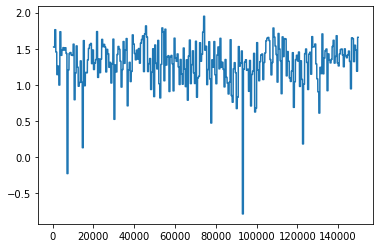

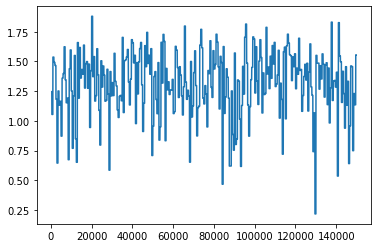

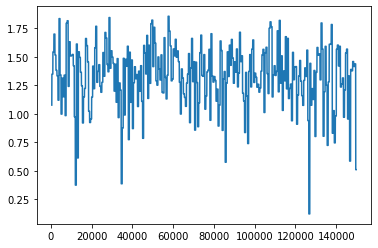

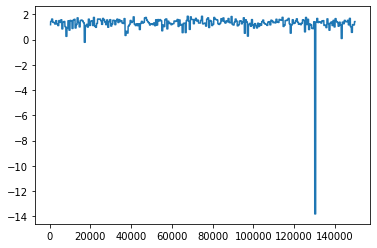

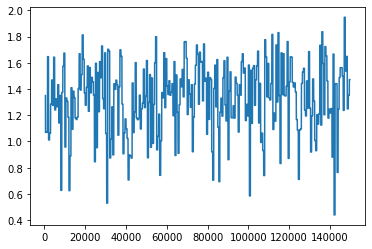

In [230]:
#show the first n simulated time series
for i in range(5):
    plt.plot(t_vec,MRI_data[:149252,i])
    plt.show()

# Real MRI data extraction code

In [231]:
#MRI_list = [MRI_data]#change these to location of MRI csv file

In [232]:
def get_MRI_data(fs_MRI=3):
    MRI_data = []
    for i in range(len(MRI_list)):
        t_vec = (t_data[i]*fs).astype('int')
        MRI=pd.read_csv(MRI_files[i],header=None,sep=' ')
        cols = [0]
        MRI.drop(MRI.columns[cols],axis=1,inplace=True)
        MRI = np.log(np.array(MRI))
        MRI= np.repeat(MRI, 1/fs_MRI*fs,axis=1).transpose()
        MRI = MRI[t_vec,:]
        MRI-=np.mean(MRI,axis=0)
        MRI/=np.std(MRI,axis=0)
        MRI_data.append(MRI)
    return MRI_data

In [233]:
#MRI_data = get_MRI_data()

# Randomize training, validation and testing sets

An important point is that because of temporal dependence data cannot be sampled independently for creating validation and testing sets. We choose a compromise which segments data into a |training|validation|test| set with a random boundary between validation and training data.

In [234]:
MRI_data = [MRI_data]#change these to location of MRI csv file

In [235]:
def rand_parts(seq, val_len,test_len):
    #creates test and validation index sets
    test_val_len = val_len+test_len
    indices = range(len(seq) - (test_val_len - 1))
    result = []
    offset = 0
    s = random.sample(indices, 1)[0]    
    result.append(seq[s:s+val_len])
    result.append(seq[s+val_len:s+val_len+test_len])
    return result

In [236]:
from sklearn.preprocessing import scale
test_val_frac = 0.2
test_inds = []
power_test = []
power_train = []
power_val = []
MRI_test = []
MRI_val = []
MRI_train = []
for i in range(len(MRI_data)):
    inds = (t_data[i]*fs).astype(int)
    test_val_size = int(len(t_data[i])*test_val_frac)
    tv_inds = rand_parts(inds,test_val_size,test_val_size)
    power_test.append(scale(power_data[i][tv_inds[0],:]))
    power_val.append(scale(power_data[i][tv_inds[1],:]))
    power_train.append(scale(np.array([power_data[i][k,:] for k,x in enumerate(t_data[i]) 
                                 if k not in tv_inds[0] and k not in tv_inds[1]])))
    MRI_test.append(scale(MRI_data[i][tv_inds[0],:]))
    MRI_val.append(scale(MRI_data[i][tv_inds[1],:]))
    MRI_train.append(scale(np.array([MRI_data[i][k,:] for k,x in enumerate(t_data[i]) 
                                 if k not in tv_inds[0] and k not in tv_inds[1]])))

In [237]:
#concatenate all data sets for model training/testing/validation
power_train = np.concatenate(power_train)
MRI_train = np.concatenate(MRI_train)
power_val = np.concatenate(power_val)
MRI_val = np.concatenate(MRI_val)
power_test = np.concatenate(power_test)
MRI_test = np.concatenate(MRI_test)

In [238]:
#Optionally train only on low frequency EEG bands
power_train = power_train[:,low_bands]
power_val = power_val[:,low_bands]
power_test = power_test[:,low_bands]

## CNN model

In [239]:

CNNmodel = tf.keras.Sequential()
CNNmodel.add(tf.keras.layers.Dropout(0.2))
CNNmodel.add(tf.keras.layers.Dense(128, input_shape=(power_train.shape[1],),activation="relu"))
CNNmodel.add(tf.keras.layers.Dropout(0.2))
CNNmodel.add(tf.keras.layers.Dense(128,activation="relu"))
CNNmodel.add(tf.keras.layers.Dropout(0.2))
CNNmodel.add(tf.keras.layers.Dense(MRI_train.shape[1],activation="linear"))
l = tf.keras.losses.LogCosh()
CNNmodel.compile(optimizer='Adam', loss=l)

In [240]:
power_train.shape,MRI_train.shape

((89921, 20), (89921, 20))

In [241]:
random.seed(10062020)
CNNmodel.fit(power_train, MRI_train, batch_size=128, epochs=5)

Epoch 1/5
 18/703 [..............................] - ETA: 4s - loss: 0.3686 

2022-04-29 18:41:10.305421: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


703/703 [==============================] - 4s 5ms/step - loss: 0.3208
Epoch 2/5
703/703 [==============================] - 4s 6ms/step - loss: 0.2912
Epoch 3/5
703/703 [==============================] - 4s 6ms/step - loss: 0.2755
Epoch 4/5
703/703 [==============================] - 4s 5ms/step - loss: 0.2650
Epoch 5/5
703/703 [==============================] - 4s 5ms/step - loss: 0.2579


In [242]:
y_pred=CNNmodel.predict(power_train)
y = MRI_train
y_pred_mean=np.mean(y_pred,axis=1)
y_mean = np.mean(y,axis=1)
print(l(y,y_pred))
print(np.corrcoef(y_mean,y_pred_mean))

2022-04-29 18:41:31.540571: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


tf.Tensor(0.1995809, shape=(), dtype=float32)
[[1.         0.72541548]
 [0.72541548 1.        ]]


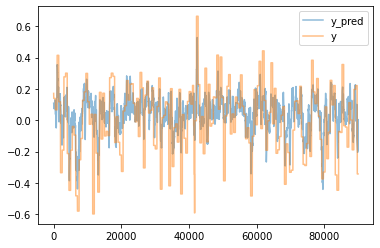

In [243]:
plt.plot(y_pred_mean,label='y_pred',alpha=0.5)
plt.plot(y_mean,label='y',alpha=0.5)
# plt.plot(np.transpose(MRI_data)[:,2],label='y')
plt.legend()

## LSTM Model 

In [244]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding, Dense, LSTM
model = tf.keras.Sequential()
model.add(layers.Embedding(input_dim=power_train.shape[1], output_dim=64))
model.add(LSTM(64))
model.add(tf.keras.layers.Dense(128, input_shape=(power_train.shape[1],),activation="relu"))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(128,activation="relu"))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(MRI_train.shape[1],activation="linear"))
#l = tf.keras.losses.BinaryCrossentropy()
l = tf.keras.losses.LogCosh()
model.compile(optimizer='Adam', loss=l)


In [245]:
model.fit(power_train, MRI_train, batch_size=128, epochs=5)

Epoch 1/5


2022-04-29 18:41:47.271539: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-29 18:41:47.437780: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  4/703 [..............................] - ETA: 14s - loss: 0.3448 

2022-04-29 18:41:47.545471: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


703/703 [==============================] - 13s 18ms/step - loss: 0.3296
Epoch 2/5
703/703 [==============================] - 12s 18ms/step - loss: 0.2937
Epoch 3/5
703/703 [==============================] - 12s 17ms/step - loss: 0.2660
Epoch 4/5
703/703 [==============================] - 12s 17ms/step - loss: 0.2449
Epoch 5/5
703/703 [==============================] - 12s 17ms/step - loss: 0.2293


In [246]:
y_pred=model.predict(power_train)
y = MRI_train
y_pred_mean=np.mean(y_pred,axis=1)
y_mean = np.mean(y,axis=1)
#print(l(y,y_pred))
print(np.corrcoef(y_mean,y_pred_mean))

2022-04-29 18:42:51.722555: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-29 18:42:51.762691: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[1.         0.66117973]
 [0.66117973 1.        ]]


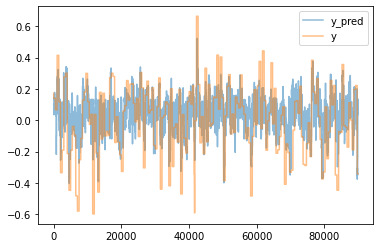

In [247]:
plt.plot(y_pred_mean,label='y_pred',alpha=0.5)
plt.plot(y_mean,label='y',alpha=0.5)
# plt.plot(np.transpose(MRI_data)[:,2],label='y')
plt.legend()

## RNN model 

In [28]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dropout(0.2))
model.add(layers.Embedding(input_dim=power_train.shape[1], output_dim=64))

# The output of GRU will be a 3D tensor of shape (batch_size, timesteps, 256)
model.add(layers.GRU(256, return_sequences=True))

# The output of SimpleRNN will be a 2D tensor of shape (batch_size, 128)
model.add(layers.SimpleRNN(128))
model.add(tf.keras.layers.Dense(128, input_shape=(power_train.shape[1],),activation="relu"))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(128,activation="relu"))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(MRI_train.shape[1],activation="linear"))
l = tf.keras.losses.LogCosh()
model.compile(optimizer='Adam', loss=l)

In [29]:
model.fit(power_train, MRI_train, batch_size=128, epochs=5)

Epoch 1/5


2022-04-27 22:14:49.504289: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-27 22:14:49.719401: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  1/703 [..............................] - ETA: 15:58 - loss: 0.3391

2022-04-27 22:14:50.070945: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


703/703 [==============================] - 171s 242ms/step - loss: 0.3109
Epoch 2/5
703/703 [==============================] - 181s 257ms/step - loss: 0.2592
Epoch 3/5
703/703 [==============================] - 183s 260ms/step - loss: 0.2311
Epoch 4/5
703/703 [==============================] - 187s 267ms/step - loss: 0.2136
Epoch 5/5
703/703 [==============================] - 193s 274ms/step - loss: 0.2007


In [30]:
model.save('./modelRNN')

2022-04-27 22:30:04.393837: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./modelRNN/assets


INFO:tensorflow:Assets written to: ./modelRNN/assets


In [31]:
y_pred=model.predict(power_train)
y = MRI_train
y_pred_mean=np.mean(y_pred,axis=1)
y_mean = np.mean(y,axis=1)
#print(l(y,y_pred))
print(np.corrcoef(y_mean,y_pred_mean))

2022-04-27 22:30:05.483045: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-27 22:30:05.536035: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[1.         0.70810529]
 [0.70810529 1.        ]]


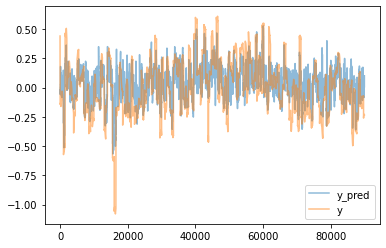

In [32]:
plt.plot(y_pred_mean,label='y_pred',alpha=0.5)
plt.plot(y_mean,label='y',alpha=0.5)
# plt.plot(np.transpose(MRI_data)[:,2],label='y')
plt.legend()

## Graph CNN 

In [248]:
import torch


In [659]:
from pyedflib import highlevel
def write_edf(eeg_data):
    # write an edf file
    signals = power_train.reshape(20,-1)
    #[:, :10].reshape(10,-1)

    ch = ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE',
     'EEG A2-A1']

    channel_names = ch[:20]
    print()
    #['ch1', 'ch2', 'ch3', 'ch4', 'ch5', 'ch6','ch7','ch9','ch10','ch11']
    signal_headers = highlevel.make_signal_headers(channel_names, sample_frequency=600)
    highlevel.write_edf('edf_file.edf', signals, signal_headers)
    return 'edf_file.edf'

In [660]:
power_train.shape

(89921, 20)

In [661]:
write_edf(power_train)

'edf_file.edf'

In [662]:
import eegraph
G = eegraph.Graph()
file ='edf_file.edf'
G.load_data(file)

Extracting EDF parameters from /Users/ssackstein/Desktop/JHU/Capstone/EEGtransformMRI/edf_file.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...

EEG Information.
Number of Channels: 20
Sample rate: 600.0 Hz.
Duration: 149.998 seconds.
Channel Names: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']


In [663]:
graphs, connectivity_matrix = G.modelate(window_size = 600, bands = ['delta', 'theta', 'alpha', 'beta', 'gamma'],connectivity = 'squared_coherence',threshold=0.001)

Model Data.
Squared_coherence_Estimator()
Frequency Bands: ['delta', 'theta', 'alpha', 'beta', 'gamma'] [True, True, True, True, True]
Intervals:  [(0, 89999.0)]

Threshold: 0.001
Number of graphs created: 5


In [664]:
for i in range(len(graphs.keys())): 
    #if len(graphs[i].edges) > 20:
    print(i, len(graphs[i].edges))

0 165
1 178
2 188
3 190
4 190


In [665]:
G.visualize(graphs[4], 'graph_1')

In [696]:
def get_edgedict(nodes, node=None):
    nodeslist=[i for i in nodes]
    nodesval=[i for i in range(len(nodes))]
    nodesdict= dict(zip(nodeslist,nodesval))
    if node!=None:
        return nodesdict, nodesdict[node]
    return nodesdict, 0
def per_edge(edge_list, nodes):
    nodesdict, node = get_edgedict(nodes)
    node_names = [i for i in nodesdict.keys()]
    node_edg_flat =dict()
    for i in node_names:
        n=nodesdict[i]
        if len(edge_list.edges(i))>5:
            node_edg_flat[n]=[nodesdict[j[1]] for j in edge_list.edges(i)]
        else:
            node_edg_flat[n]=[n]*(len(edge_list.nodes)-1)
    return node_edg_flat
edges_per= per_edge(edge_list=graphs[3], nodes=graphs[3].nodes)    

In [712]:
nodesdict,node_x =get_edgedict(nodes=graphs[3].nodes)

In [697]:
len(graphs[3].nodes)

20

In [698]:
edges_min=min([len(i) for i in edges_per.values()])
edges= [i[:edges_min] for i in edges_per.values()]


In [699]:
edges,edges_min

([[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
  [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
  [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
  [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
  [0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
  [0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
  [0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
  [0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
  [0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
  [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19],
  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19],
  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19],
  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19],
  [0, 1, 2

In [700]:
edges_array=np.array(edges).flatten()

In [702]:
connect= [len(i) for i in edges_per.values()]
c= edges_min
l=[]
for i in range(len(connect)*c):
    if i%c==0:
        l.append([int(i/c)]*c)
l = np.array(l).flatten()

In [703]:
edge_index = torch.tensor(np.array([l,edges_array]))
edge_index.shape

torch.Size([2, 380])

In [704]:
weights=np.array([i[2] for i in graphs[4].edges().data("weight", default=0.1)])

In [714]:
[i for i in graphs[4].edges().data("weight", default=0.1)]

[('Fp1', 'F3', 0.0334379018521267),
 ('Fp1', 'C3', 0.16285139130542386),
 ('Fp1', 'P3', 0.21901074007313137),
 ('Fp1', 'O1', 0.13288905633430192),
 ('Fp1', 'F7', 0.09039383934091956),
 ('Fp1', 'T3', 0.1556204049373424),
 ('Fp1', 'T5', 0.10293044314372367),
 ('Fp1', 'Fz', 0.2698279472074552),
 ('Fp1', 'Fp2', 0.054341566111075136),
 ('Fp1', 'F4', 0.12328138983161081),
 ('Fp1', 'C4', 0.08019651298125259),
 ('Fp1', 'P4', 0.11982557302444137),
 ('Fp1', 'O2', 0.10256698512009896),
 ('Fp1', 'F8', 0.16660041327584446),
 ('Fp1', 'T4', 0.13372328702451247),
 ('Fp1', 'T6', 0.26105014695126455),
 ('Fp1', 'Cz', 0.12028643098596999),
 ('Fp1', 'Pz', 0.1380660724877201),
 ('F3', 'C3', 0.01924640055405097),
 ('F3', 'P3', 0.030970815683609827),
 ('F3', 'O1', 0.013880028247348908),
 ('F3', 'F7', 0.009762119537430477),
 ('F3', 'T3', 0.0872361417473323),
 ('F3', 'T5', 0.04212345526350254),
 ('F3', 'Fz', 0.015738269479533915),
 ('F3', 'Fp2', 0.03592844048342346),
 ('F3', 'F4', 0.026732432029454436),
 ('F3',

In [705]:
nl=[]
for j in graphs[4].edges().data("weight", default=0.1):   
    if nodesdict[j[0]] == node_x: 
        nl.append(j[2])
       
    

In [749]:
def node_weight(edge_list, nodes,weight):
    nodesdict, node = get_edgedict(nodes)
    node_names = [i for i in nodesdict.keys()]
    node_edg_flat =dict()
    for i in node_names:
        n=nodesdict[i]
        if len(edge_list.edges(i))>18:
            nl=[0.1]
            for j in weight.data("weight", default=0.1):   
                if nodesdict[j[0]] == node_x: 
                    nl.append(j[2])
            node_edg_flat[n]=nl
        else:
            node_edg_flat[n]=[0.1]*(len(edge_list.nodes))
    return node_edg_flat
node_weight_per= node_weight(edge_list=graphs[3], nodes=graphs[3].nodes, weight=graphs[4].edges())    

In [750]:

node_weight_per_min=min([len(i) for i in node_weight_per.values()])
nweight= [i[:node_weight_per_min] for i in node_weight_per.values()]
weight_array=np.array(nweight).flatten()
weight_array.shape

(380,)

In [751]:
node_weight_per_min

19

In [794]:
weight_array=np.array(weight_array,np.double).astype(np.float32)

In [795]:
edge_attr =torch.tensor(weight_array)
#edge_attr=edge_attr.type(torch.DoubleTensor)

In [796]:
#edge_attr=edge_attr.double()
edge_attr

tensor([0.1000, 0.0334, 0.1629, 0.2190, 0.1329, 0.0904, 0.1556, 0.1029, 0.2698,
        0.0543, 0.1233, 0.0802, 0.1198, 0.1026, 0.1666, 0.1337, 0.2611, 0.1203,
        0.1381, 0.1000, 0.0334, 0.1629, 0.2190, 0.1329, 0.0904, 0.1556, 0.1029,
        0.2698, 0.0543, 0.1233, 0.0802, 0.1198, 0.1026, 0.1666, 0.1337, 0.2611,
        0.1203, 0.1381, 0.1000, 0.0334, 0.1629, 0.2190, 0.1329, 0.0904, 0.1556,
        0.1029, 0.2698, 0.0543, 0.1233, 0.0802, 0.1198, 0.1026, 0.1666, 0.1337,
        0.2611, 0.1203, 0.1381, 0.1000, 0.0334, 0.1629, 0.2190, 0.1329, 0.0904,
        0.1556, 0.1029, 0.2698, 0.0543, 0.1233, 0.0802, 0.1198, 0.1026, 0.1666,
        0.1337, 0.2611, 0.1203, 0.1381, 0.1000, 0.0334, 0.1629, 0.2190, 0.1329,
        0.0904, 0.1556, 0.1029, 0.2698, 0.0543, 0.1233, 0.0802, 0.1198, 0.1026,
        0.1666, 0.1337, 0.2611, 0.1203, 0.1381, 0.1000, 0.0334, 0.1629, 0.2190,
        0.1329, 0.0904, 0.1556, 0.1029, 0.2698, 0.0543, 0.1233, 0.0802, 0.1198,
        0.1026, 0.1666, 0.1337, 0.2611, 

In [780]:
#edge_attr =torch.tensor([1. for i in range(edge_index.shape[1])])

In [797]:
edge_attr.shape, edge_index.shape

(torch.Size([380]), torch.Size([2, 380]))

In [798]:
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import DCRNN
from tqdm import tqdm
class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features):
        super(RecurrentGCN, self).__init__()
        self.recurrent = DCRNN(node_features, 128, 1)
        self.linear = torch.nn.Linear(128, 1)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight)
        h = F.relu(h)
        h = self.linear(h)
        return h

from torch_geometric_temporal.signal import temporal_signal_split



model = RecurrentGCN(node_features = 20)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()
time=0
#for epoch in tqdm(range(sim_time)):
cost = 0

y_hat = model(torch.tensor(power_train[:,:], dtype=torch.float), edge_index,edge_attr)
cost = cost + torch.mean((y_hat-torch.tensor(MRI_train[:,:], dtype=torch.float))**2)
cost = cost 
time+=1
cost.backward()
optimizer.step()
optimizer.zero_grad()
model.eval()


RecurrentGCN(
  (recurrent): DCRNN(
    (conv_x_z): DConv(148, 128)
    (conv_x_r): DConv(148, 128)
    (conv_x_h): DConv(148, 128)
  )
  (linear): Linear(in_features=128, out_features=1, bias=True)
)

In [799]:
power_train[:,:].shape

(89921, 20)

In [800]:
y_hat.detach().numpy().shape,MRI_train.shape

((89921, 1), (89921, 20))

In [801]:
#cost = 0

#y_hat = model(torch.tensor(power_train[:,:], dtype=torch.float), edge_index, edge_attr)
#cost = cost + torch.mean((y_hat-torch.tensor(MRI_train[:,:], dtype=torch.float))**2)
#cost = cost / (time+1)
cost = cost.item()
print("MSE: {:.4f}".format(cost))

MSE: 1.0007


In [802]:
y_pred=(torch.tensor(MRI_train[:,:], dtype=torch.float)-y_hat).detach().numpy()
y = MRI_train
y_pred_mean=np.mean(y_pred,axis=1)
y_mean = np.mean(y,axis=1)


In [803]:
print(np.corrcoef(y_mean,y_pred_mean))

[[1.         0.99962736]
 [0.99962736 1.        ]]


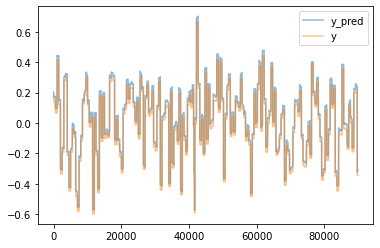

In [804]:
plt.plot(y_pred_mean,label='y_pred',alpha=0.5)
plt.plot(y_mean,label='y',alpha=0.5)

plt.legend()

# Simple models based on simulated data does not generalize well
The model based on simulated data does not generalize well.

In [41]:
y_pred=CNNmodel.predict(power_val)
y = MRI_val
y_pred_mean=np.mean(y_pred,axis=1)
y_mean = np.mean(y,axis=1)
print(l(y,y_pred))
print(np.corrcoef(y_mean,y_pred_mean))

tf.Tensor(0.38337782, shape=(), dtype=float32)
[[1.         0.08891975]
 [0.08891975 1.        ]]


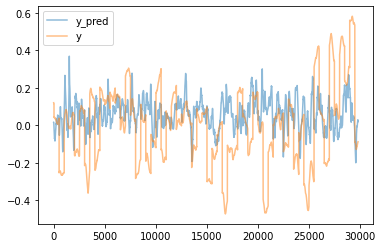

In [42]:
plt.plot(y_pred_mean,label='y_pred',alpha=0.5)
plt.plot(y_mean,label='y',alpha=0.5)
# plt.plot(np.transpose(MRI_data)[:,2],label='y')
plt.legend()

# Cortical MRI ROI Only Fitting

This model is based on real cortical MRI ROIs from the Harvard-Oxford cortical parcellation.

In [78]:
cort_train = MRI_train[:,:4]
cort_val = MRI_val[:,4:]
cort_test = MRI_test[:,:4]
sub_train = MRI_train[:,4:]
sub_val = MRI_val[:,:4]
sub_test = MRI_test[:,:4]

In [85]:
MRI_train[:,:4].shape

(89921, 4)

In [86]:

model2 = tf.keras.Sequential()
model2.add(tf.keras.layers.Dropout(0.2))
model2.add(tf.keras.layers.Dense(128, input_shape=(cort_train.shape[1],),activation="relu"))
model2.add(tf.keras.layers.Dropout(0.2))
model2.add(tf.keras.layers.Dense(128,activation="relu"))
model2.add(tf.keras.layers.Dropout(0.2))
model2.add(tf.keras.layers.Dense(sub_train.shape[1],activation="linear"))
l = tf.keras.losses.LogCosh()
model2.compile(optimizer='Adam', loss=l)

In [87]:
random.seed(100)
model2.fit(MRI_train[:,:4], MRI_train[:,4:], batch_size=128, epochs=50)

Epoch 1/50
  9/703 [..............................] - ETA: 4s - loss: 0.3701  

2022-04-27 22:53:33.809845: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


703/703 [==============================] - 4s 6ms/step - loss: 0.3400
Epoch 2/50
703/703 [==============================] - 4s 6ms/step - loss: 0.3195
Epoch 3/50
703/703 [==============================] - 4s 6ms/step - loss: 0.3054
Epoch 4/50
703/703 [==============================] - 4s 5ms/step - loss: 0.2954
Epoch 5/50
703/703 [==============================] - 4s 6ms/step - loss: 0.2877
Epoch 6/50
703/703 [==============================] - 4s 6ms/step - loss: 0.2811
Epoch 7/50
703/703 [==============================] - 4s 6ms/step - loss: 0.2766
Epoch 8/50
703/703 [==============================] - 4s 6ms/step - loss: 0.2724
Epoch 9/50
703/703 [==============================] - 4s 6ms/step - loss: 0.2692
Epoch 10/50
703/703 [==============================] - 4s 6ms/step - loss: 0.2655
Epoch 11/50
703/703 [==============================] - 4s 6ms/step - loss: 0.2629
Epoch 12/50
703/703 [==============================] - 4s 6ms/step - loss: 0.2607
Epoch 13/50
703/703 [===============

In [81]:
#model2.save('/model2')

In [82]:
#model2 = tf.keras.models.load_model('/MRI/model2')

In [91]:
y_pred=model2.predict(cort_train)
y = MRI_train[:,4:]
y_pred_mean=np.mean(y_pred,axis=1)
y_mean = np.mean(y,axis=1)
# print(l(y,y_pred))
print(np.corrcoef(y_mean,y_pred_mean))

[[1.         0.75376143]
 [0.75376143 1.        ]]


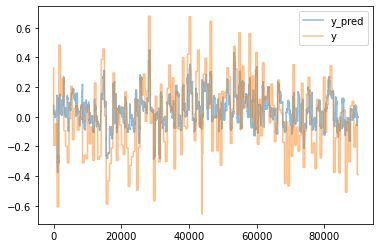

In [92]:
plt.plot(y_pred_mean,label='y_pred',alpha=0.5)
plt.plot(y_mean,label='y',alpha=0.5)
# plt.plot(np.transpose(MRI_data)[:,2],label='y')
plt.legend()

In [75]:
y_pred=model2.predict(cort_val)
y = sub_val
y_pred_mean=np.mean(y_pred,axis=1)
y_mean = np.mean(y,axis=1)
print(l(y,y_pred))
print(np.corrcoef(y_mean,y_pred_mean))

2022-04-27 22:41:36.028934: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


tf.Tensor(0.3925294, shape=(), dtype=float32)
[[1.         0.12406183]
 [0.12406183 1.        ]]


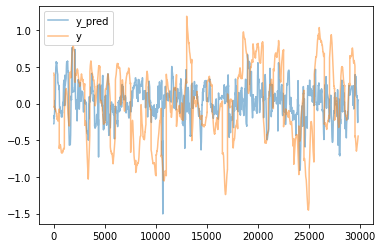

In [76]:
plt.plot(y_pred_mean,label='y_pred',alpha=0.5)
plt.plot(y_mean,label='y',alpha=0.5)
# plt.plot(np.transpose(MRI_data)[:,2],label='y')
plt.legend()

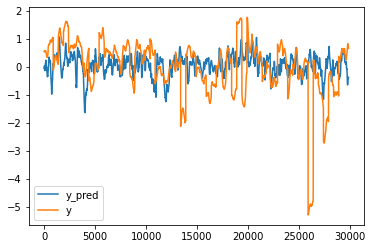

In [93]:
i=1
y_pred=CNNmodel.predict(power_test)[:,i]
y=MRI_test[:,i]
plt.plot(y_pred,label='y_pred')
plt.plot(y,label='y')
# plt.plot(np.transpose(MRI_data)[:,2],label='y')
plt.legend()

In [94]:
np.corrcoef(y_pred,y)

array([[1.        , 0.15808112],
       [0.15808112, 1.        ]])

# Conclusion

Real data generalises marginally better than simulated MRI/EEG data based on mostly uncorrelated colored noise. More sophisticated models e.g. deep RNNs may help to generalise further.